In [3]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
import urllib.request as ul
#import quandl as ql
import scipy.optimize as sco

In [ ]:
pip install yfinance

In [45]:
end = dt.datetime.today()
start = end - dt.timedelta(365)

tickers = ['AAPL', 'ATVI', 'TSLA', 'MSFT', 'GE', 'AMD', 'DIS']
bench = ['SPY', 'IWM', 'DIA']

data2 = yf.download(tickers=tickers+bench, start=start, end=end)
data = yf.download(tickers=tickers+bench, start=start, end=end)['Adj Close']

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed


In [12]:
data.head()

,AAPL,AMD,ATVI,DIA,DIS,GE,IWM,MSFT,SPY,TSLA
Date,,,,,,,,,,
2020-07-27,94.175430,68.970001,81.236656,261.226288,116.309998,6.682753,146.087540,201.895142,318.476440,307.920013
2020-07-28,92.628365,67.610001,80.331047,259.242065,116.180000,6.862021,144.632599,200.082703,316.456543,295.298004
2020-07-29,94.403893,76.089996,80.808731,260.784241,115.610001,6.563240,147.819611,202.103119,320.348541,299.821991
2020-07-30,95.546204,78.199997,81.306320,258.603668,115.660004,6.234581,147.235626,201.944656,319.205597,297.497986
2020-07-31,105.548805,77.430000,82.231842,259.654663,116.940002,6.045352,145.849991,203.044006,321.727966,286.152008


In [64]:
data_norm = np.log(data[tickers]/data[tickers].shift(1))
data_norm

,AAPL,ATVI,TSLA,MSFT,GE,AMD,DIS
Date,,,,,,,
2020-07-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-28,-0.016564,-0.011210,-0.041855,-0.009018,0.026472,-0.019916,-0.001118
2020-07-29,0.018987,0.005929,0.015204,0.010047,-0.044518,0.118161,-0.004918
2020-07-30,0.012028,0.006139,-0.007781,-0.000784,-0.051373,0.027353,0.000432
2020-07-31,0.099564,0.011319,-0.038884,0.005429,-0.030822,-0.009895,0.011006
...,...,...,...,...,...,...,...
2021-07-20,0.025642,0.013311,0.021857,0.008304,0.056695,0.006103,0.021734
2021-07-21,-0.005145,-0.003722,-0.007919,0.007419,0.029482,0.026061,0.000792
2021-07-22,0.009583,-0.007708,-0.009245,0.016704,-0.029482,0.019932,-0.009999


In [65]:
np.random.seed(42)
num_ports = 6000
all_weights = np.zeros((num_ports, len(data_norm.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(7))
    weights = weights/np.sum(weights)
    
    # Save weights
    all_weights[x,:] = weights
    
    # Expected return
    ret_arr[x] = np.sum( (data_norm.mean() * weights * 252))
    
    # Expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(data_norm.cov()*252, weights)))
    
    # Sharpe Ratio
    sharpe_arr[x] = ret_arr[x]/vol_arr[x]

In [66]:
print('Max sharpe ratio in the array: {}'.format(sharpe_arr.max()))
print('Its location in the arry: {}'.format(sharpe_arr.argmax()))

Max sharpe ratio in the array: 2.3654249568220767
Its location in the arry: 203


In [67]:
max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol = vol_arr[sharpe_arr.argmax()]

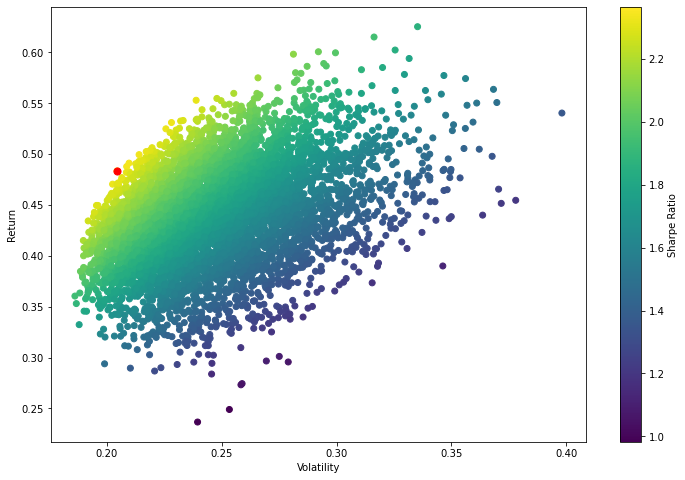

In [68]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=50) # red dot
plt.show()

In [69]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(data_norm.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(data_norm.cov()*252, weights)))
    sr = ret/vol
    return np.array([ret, vol, sr])

def neg_sharpe(weights):
# the number 2 is the sharpe ratio index from the get_ret_vol_sr
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    #return 0 if sum of the weights is 1
    return np.sum(weights)-1

In [71]:
#constraints is where you invert the minimize function
cons = ({'type': 'eq', 'fun':check_sum})
bounds = ((0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1))
init_guess = [0.142,0.142,0.142,0.142,0.142,0.142,0.142]

In [73]:
opt_results = sco.minimize(neg_sharpe, init_guess, method='SLSQP',bounds=bounds, constraints=cons)
print(opt_results)

     fun: -2.4028499339673908
     jac: array([-3.00377607e-04,  5.36337852e-01, -1.77380443e-03, -9.09000635e-04,
        7.42226839e-04,  2.47494668e-01,  7.93725252e-04])
 message: 'Optimization terminated successfully'
    nfev: 68
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([1.70143227e-01, 5.39932682e-17, 6.00323782e-02, 2.56179866e-01,
       3.34551246e-01, 0.00000000e+00, 1.79093283e-01])


In [74]:
get_ret_vol_sr(opt_results.x)

array([0.51179328, 0.21299427, 2.40284993])

In [88]:
#Go by the previous graph, 0 - 0.7
frontier_y = np.linspace(0,0.7,200)

In [77]:
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

In [89]:
frontier_x = []

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun':check_sum},
            {'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = sco.minimize(minimize_volatility,init_guess,method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])

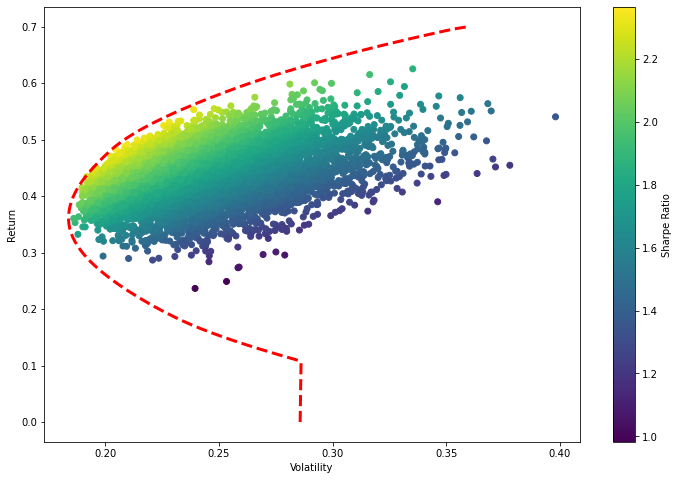

In [90]:
#3 try
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.plot(frontier_x,frontier_y, 'r--', linewidth=3)
plt.savefig('cover.png')
plt.show()